# Advanced Machine Learning Project

# By Baolin Liu

# Is it a Diploma or Is it a Marriage Certificate? 

In [1]:
import pickle
import tensorflow as tf
import tensorflow.python.platform
import glob
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.svm import SVC
from IPython.display import Image
from sklearn.externals import joblib
%matplotlib inline
from classifier import *
import pprint
import pickle

# Motivation....
# For my capstone,
# Text classfication worked well for certain documents:
- eta9089
- I-129
- I-200
- I-797
- I-94
- Paystubs
- Transcripts (mostly)
- Resumes

In [38]:
Examples = glob.glob('Examples/*')

for i in Examples:
    print i
    pprint.pprint(probability(i)[0])

Examples/9089form.pdf
('eta_9089', 0.95631053069704541)
Examples/i-129.pdf
('I-129 ', 0.93296332869414067)
Examples/I-20.pdf
('I-20(F-1)', 0.94988162501309237)
Examples/I-200_Massachusetts.pdf
('I-200', 0.94452292219309875)
Examples/I-94_original_48986.pdf
('I-94', 0.93523243663273048)
Examples/Jan_2015_pay.pdf
('Paystubs', 0.96712777423342278)
Examples/notice_i797c.png
('Transcript', 0.30119944591735154)
Examples/resume.pdf
('Resume', 0.963131929942736)
Examples/transcripts_original_31220.pdf
('Transcript', 0.93006592542670496)


# Certificates did not do as well with text classification: 

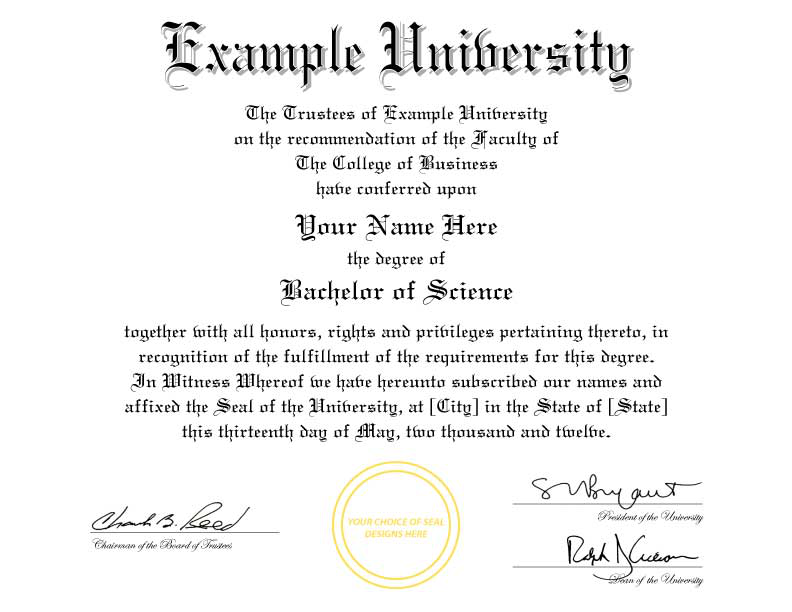

In [2]:
Image(filename='diplomas/Fake-University-Diploma-Template-04.jpg')

In [44]:
probability('diplomas/Fake-University-Diploma-Template-04.jpg')

[('Transcript', 0.33098151363705181),
 ('Diploma', 0.25303340638111355),
 ('Paystubs', 0.15840534467726003)]

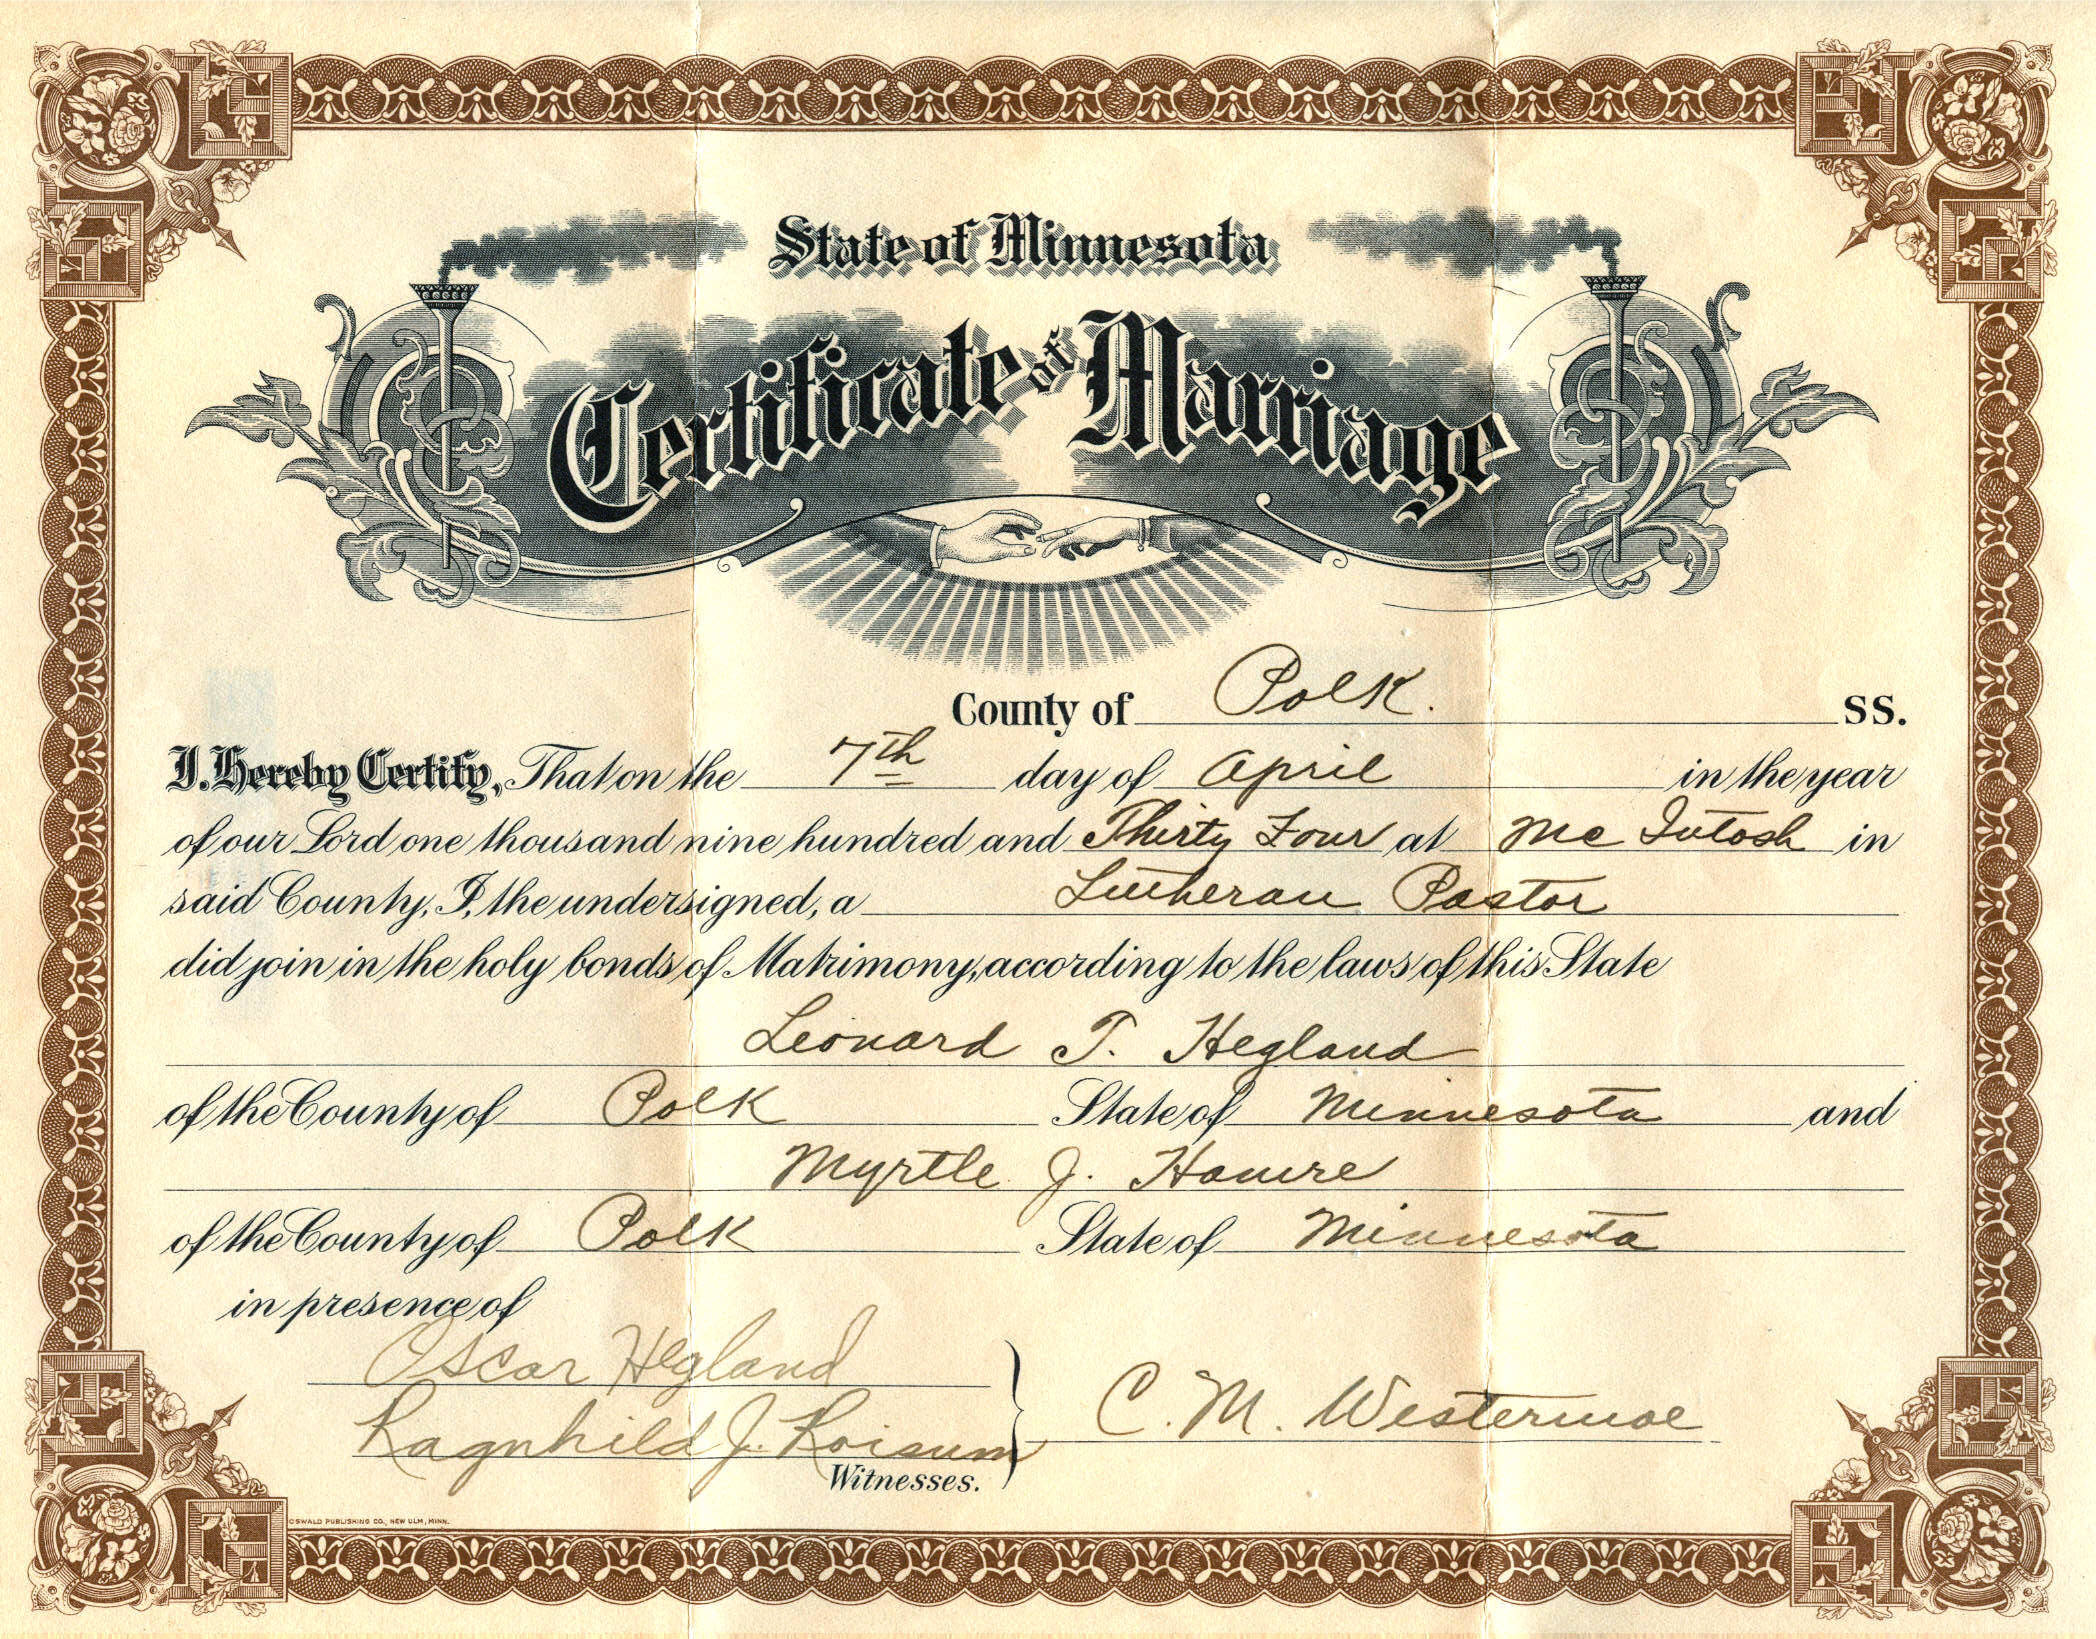

In [3]:
Image(filename='marriage/00000.jpg')

In [45]:
probability('marriage/00000.jpg')

[('Resume', 0.37998542314659101),
 ('Paystubs', 0.18989105014494465),
 ('Diploma', 0.17653597054683401)]

# So I decided to try image classification to see if my chances would improve

# But first:

- I had to gather documents to classify by searching the internet
- studied MNIST digits, how Neural Networks classified 0-9 numbers
- turn the documents into a 1D scalar
- used tensorflow as a feature extractor by using transfer learning, training the last layer
- using a pre-trained deep learning model called Inception-v3

In [9]:
list_images = glob.glob('diplomas/*') # grabbing everything stored in a folder

In [7]:
def create_graph():
    with gfile.FastGFile('classify_image_graph_def.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

# graph that represents the description of computations. 
# Then these computations will be executed within what is called sessions.
# http://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11

In [8]:
def extract_features(list_images):
    nb_features = 2048 # features, scalar length
    features = np.empty((len(list_images),nb_features))  # creating empty matrix

    create_graph() # calling the graph

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0') # calling the pre-trained network

        for ind, image in enumerate(list_images):
            try:
                image_data = gfile.FastGFile(image, 'rb').read() # uploads the file
                predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0': image_data}) # vectorize the data
                features[ind,:] = np.squeeze(predictions) # 1D array
            
            except:
                pass
    return features # nested list of 1D arrays

# http://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11

In [9]:
# features = extract_features(list_images) # creates a list of the training data

In [11]:
# pickling the data
#pickle.dump(features, open('Diploma', 'wb'))

In [30]:
# uploading the saved data
diplomas = pickle.load(open('Diploma'))
marriage = pickle.load(open('marriages'))

In [31]:
# combining things together, giving things a label 0,1
features_total = np.asarray(list(diplomas) + list(marriage))
labels_total = np.asarray(len(diplomas)*[0] + len(marriage)*[1])

In [14]:
# turning it into the format that was given to us in class
X = features_total
Y = [[i] for i in labels_total]

# Testing the data on an ANN network using Momentum...

In [16]:
# shrinking data to 2 components
from sklearn.manifold import MDS # multi-dimensional scaling
model = MDS(n_components=2, random_state=42)
X = model.fit_transform(X) 

In [21]:
def tfS(XX):
    return 1.0 / (1.0 + tf.exp(-XX)) 

def tfNeuralNet(XX, W): 
    return tfS(tf.matmul(XX, W)) 

def tfLoss(NNO, Y): 
    return tf.reduce_mean(tf.square(Y - NNO))

def tfGradW(XX, Y, W): 
    arg = tf.matmul(XX, W)
    terms = -2.0 * (Y - tfS(arg)) * tfS(arg) * tfS(-arg)

    return tf.reduce_mean((terms * XX), 0)


Tensor("Mean_9:0", shape=(2,), dtype=float32)
loss history


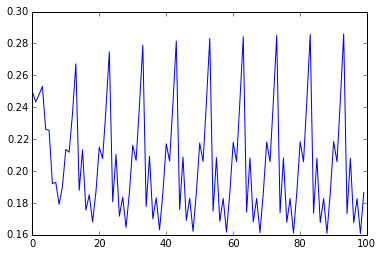

weight histories


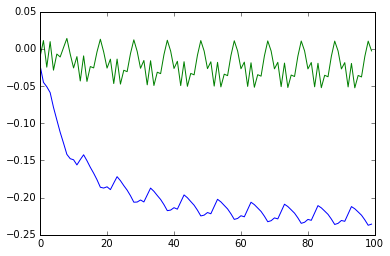

gradient histories


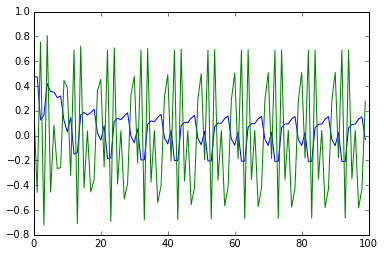

In [26]:

x = tf.placeholder(tf.float32, shape=[None, 2], name='x') # x and y are both placeholders.
y = tf.placeholder(tf.float32, shape=[None, 1], name='y') # They contain no values, only type and shape.
lr = tf.placeholder(tf.float32, shape = [1], name = 'lr')

W2 = tf.Variable(tf.zeros((2,1), dtype=tf.float32), name='W2') 
# Notice in this example, W2 is a 2 by 1 matrix; W2 is NOT the scalar that you multiply to x2 in this case.
# lr = tf.constant(1, dtype=tf.float32, name='lr') # <---- hyper-parameter here: learning rate 

nno = tfNeuralNet(x, W2) # nno stands for neural net output; includes the sigmoid already, basically, y-hat
loss = tfLoss(nno, y) # loss function node
grad = tfGradW(x, y, W2) # gradient function node 

#meta parameters
step = tf.Variable(tf.zeros((2,1), dtype=tf.float32), name='step')
beta = tf.constant(0.05, dtype=tf.float32, name='beta')
delta = tf.constant(0.05, dtype=tf.float32, name='delta')

step = beta * step + (1-beta) * delta * tf.reshape(grad, tf.shape(W2))

train = W2.assign_add(-step)


with tf.Session() as sess: # notice the body of this Session is primarily in pure Python, only 2 lines of TensorFlow
    result = sess.run(tf.initialize_all_variables()) # TensorFlow here
    miniBatchSize = 30 # <---- hyper-parameter here
    startEnd = zip(range(0, len(X), miniBatchSize), range(miniBatchSize, len(X) + 1, miniBatchSize))
    resultList = [] 
    nPasses = 10
    for iPass in range(nPasses): 
        for (s, e) in startEnd:
            
            #costVal, weight, tbSummary = sess.run([cost, gradients, merged], feed_dict={X: xTrain[s:e,], Y: yTrain[s:e], lr:[1]})

            result = sess.run([loss, grad, train], feed_dict={x: X[s:e,], y: Y[s:e], lr: [.01]}) 
            
            resultList.append(result)

print(grad)

 

gTup = [(rl[0], rl[1][0], rl[1][1], rl[2][0], rl[2][1]) for rl in resultList] 
[loss, g0, g1, w0, w1] = zip(*gTup) 

xAxis = np.array(range(len(resultList)))
#plot loss
print 'loss history'
plt.plot(xAxis, loss)
plt.show()

#plot weight histories
print 'weight histories'
plt.plot(xAxis, w0)
plt.plot(xAxis, w1)
plt.show()

#Plot gradient histories
print 'gradient histories'
plt.plot(xAxis, g0)
plt.plot(xAxis, g1)
plt.show()

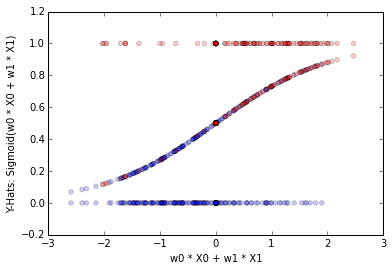

In [23]:
actual_weights = np.array([w0[-1][0], w1[-1][0]]).reshape(2, 1)

with tf.Session() as sess:
    x_axis, y_axis = sess.run([tf.matmul(x,W2), nno], feed_dict={x: X, W2: actual_weights}) 
    
colorMap = {0.0: "blue", 1.0: "red"}
colors = [colorMap[c] for c in np.asarray(Y).reshape(-1)]
plt.scatter(x_axis, Y, c=colors, alpha=0.2)    
plt.scatter(x_axis, y_axis, c=colors, alpha=0.2)
plt.xlabel("w0 * X0 + w1 * X1")
plt.ylabel("Y-Hats: Sigmoid(w0 * X0 + w1 * X1)")

In [23]:
diplomas_1 = pickle.load(open('Diploma')) # loading pickled data
marriage_1 = pickle.load(open('marriages'))

In [24]:
print len(diplomas_1)
print len(marriage_1)

198
119


In [25]:
features_total_1 = np.asarray(list(diplomas_1) + list(marriage_1)) 
labels_total_1 = np.asarray(len(diplomas_1)*[0] + len(marriage_1)*[1])  # creating 0 and 1s

In [26]:
len(labels_total_1)

317

In [27]:
y = [] # turning the data into a scalar like the MNIST digits example
# my way of doing one hot encoding
for i in labels_total_1:
    if i == 0:
        y.append([i,1])
    if i ==1:
        y.append([1,0])

In [28]:
from sklearn.manifold import MDS  # fitting the data in the mnist digit shape like in class
model = MDS(n_components=784, random_state=42)
features_total_1 = model.fit_transform(features_total_1) 

# using convolutional Networks did very poorly:

In [63]:
import tensorflow as tf

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial, name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

#inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

#reshape to image format for conv functions
x_image = tf.reshape(x, [-1,28,28,1])

#weight and bias for 1st conv
W_conv1 = weight_variable([5, 5, 1, 32], 'W_conv1')
b_conv1 = bias_variable([32], 'b_conv1')

#conv and max-pool - layers 1 and 2
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_bn1 = tf.contrib.layers.batch_norm(h_pool1)

#weight and bias for 2nd convolution
W_conv2 = weight_variable([5, 5, 32, 64], 'W_conv2')
b_conv2 = bias_variable([64], 'b_conv2')

#ops for layers 3 and 4
h_conv2 = tf.nn.relu(conv2d(h_bn1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_bn2 = tf.contrib.layers.batch_norm(h_pool2)

W_conv3 = weight_variable([5, 5, 64, 128], 'W_conv3')
b_conv3 = bias_variable([128], 'b_conv3')

h_conv3 = tf.nn.relu(conv2d(h_bn2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)
h_bn3 = tf.contrib.layers.batch_norm(h_pool3)
print h_bn3

#reshape for FC layers
W_fc1 = weight_variable([4 * 4 * 128, 1024], 'W_fc1')
b_fc1 = bias_variable([1024], 'b_fc1')


#layer 5
h_pool3_flat = tf.reshape(h_bn3, [-1, 4*4*128])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
h_fc1bn = tf.contrib.layers.batch_norm(h_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 2], 'W_fc2')
b_fc2 = bias_variable([2], 'b_fc2')
h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
h_fc2bn = tf.contrib.layers.batch_norm(h_fc2)

y_conv=tf.nn.softmax(h_fc2bn)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(0.0000001).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#histograms
tVar = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]
tVarNames = ['W_conv1', 'b_conv1', 'W_conv2', 'b_conv2', 'W_fc1', 'b_fc1', 'W_fc2', 'b_fc2']
merged = tf.merge_summary([tf.histogram_summary(tv.name, tv) for (tvName, tv) in zip(tVarNames, tVar)])

xTrain, xTest, yTrain, yTest = cross_validation.train_test_split(features_total_1, y, random_state=42,test_size=.5)
with tf.Session() as sess:
    result = sess.run(tf.initialize_all_variables())
    #writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 10
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 10
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            #[cost, tbSummary] = sess.run([train_step, merged], feed_dict={x: xTrain[s:e,], y_: yTrain[s:e], keep_prob:1.0})
            cost = sess.run(train_step, feed_dict={x: xTrain[s:e,], y_: yTrain[s:e], keep_prob:.01})
            #writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(cost)
        testResult = sess.run([accuracy], feed_dict={x:xTest, y_:yTest, keep_prob: .01})
        print iPass, testResult

Tensor("BatchNorm_2/batchnorm/add_1:0", shape=(?, 4, 4, 128), dtype=float32)
0 [0.52830189]
1 [0.4528302]
2 [0.51572329]
3 [0.50943398]
4 [0.49056605]
5 [0.52830189]
6 [0.52201259]
7 [0.50314468]
8 [0.50314468]
9 [0.50314468]


# I believe this is because the way the features are extracted, the values are in decimals and it is very hard for the CNN to detect

# 3 layer fully connected neural network from class did a lot better:

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from math import sqrt

tf.reset_default_graph() 
g = tf.Graph() 
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 784]) 
    Y = tf.placeholder(tf.float32, shape=[None, 2])


    lr = tf.placeholder(tf.float32, shape=[1], name='lr')
    weight_shape = [784, 2] 
    [n_inputs, n_outputs] = weight_shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs)) 
    w = tf.Variable(tf.random_normal(weight_shape, stddev=0.01), name='w')  
 

    #define network
    logits = tf.matmul(X, w) 
    py_x = tf.nn.softmax(logits) #
    y_pred = tf.argmax(py_x, dimension=1) 

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost') 
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost') 

    #extract gradients
    gradients = tf.train.AdadeltaOptimizer(1).minimize(cost) 
    
    
    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weights over time', w)
    merged = tf.merge_summary([summary1, summary2]) 
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.initialize_all_variables())
    #writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 30
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 100
    iteration = 100
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            costVal, weight, tbSummary = sess.run([cost, gradients, merged], feed_dict={X: xTrain[s:e,], Y: yTrain[s:e], lr:[1]})
            # When trainW is called, it will return the updated weights
            #writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 10 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTest})
            print iPass, np.mean(np.argmax(yTest, axis=1) == testResult) #accuracy

0 0.710691823899
10 0.779874213836
20 0.792452830189
30 0.805031446541
40 0.805031446541
50 0.805031446541
60 0.798742138365
70 0.792452830189
80 0.792452830189
90 0.792452830189


# Graphs shows loss, which means that it is working:

cost history


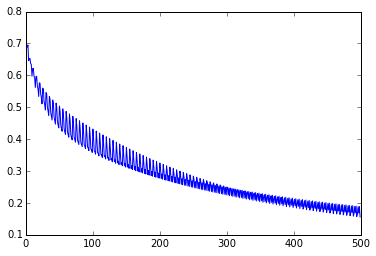

mean loss value: 0.298663556576


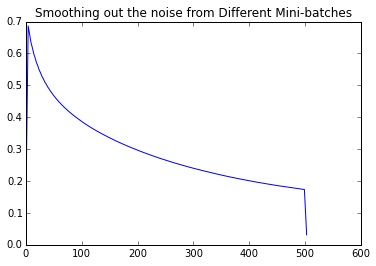

In [67]:
# Remember to open tensorboard, type: tensorboard --logdir=logs


#plot loss
xAxis = range(len(costList))
print 'cost history'
plt.plot(xAxis, costList)
plt.show()

print "mean loss value: {}". format(np.mean(costList))

width_of_conv = len(startEnd) # smoothing over different mini-batches
convo = np.ones((width_of_conv)) * 1.0 / width_of_conv
convOut = np.convolve(costList, convo)

plt.plot(convOut)
plt.title('Smoothing out the noise from Different Mini-batches')
plt.show() 

# 4 Layer Example in Class w/gradient clipping saw a slight improvement

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from math import sqrt


tf.reset_default_graph() 
g = tf.Graph() 
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 784])  
    Y = tf.placeholder(tf.float32, shape=[None, 2]) 
 
    lr = tf.placeholder(tf.float32, shape=[1], name='lr')

    
    [n_inputs, n_outputs] = weight_shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))  #from glorot paper

    w1 = tf.Variable(tf.random_normal([784,625], stddev=0.1), name='w1')
    w2 = tf.Variable(tf.random_normal([625,300], stddev=0.1), name='w2')
    w3 = tf.Variable(tf.random_normal([300,2], stddev=0.1), name='w3')
    
    b1 = tf.Variable(tf.zeros([1,625],dtype=tf.float32), name='b1')
    b2 = tf.Variable(tf.zeros([1,300],dtype=tf.float32), name='b2')
    b3 = tf.Variable(tf.zeros([1,2],dtype=tf.float32), name='b3')

    
    h1 = tf.nn.relu(tf.matmul(X, w1)+b1)  #look under Neural Net -> Activation in API left column
    h2 = tf.nn.relu(tf.matmul(h1, w2)+b2)
    logits = tf.matmul(h2, w3) + b3
    py_x = tf.nn.softmax(logits)
    y_pred = tf.argmax(py_x, dimension=1)

    

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost')
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost') 

    #extract gradients
   
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    gvs = optimizer.compute_gradients(cost, var_list = [w1,w2,w3])
    capped_gvs = [(tf.clip_by_value(grad, -.5, .5), var) for grad, var in gvs]
    clipped_grads = optimizer.apply_gradients(capped_gvs)

    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weights over time1', w1)
    summary3 = tf.histogram_summary('Weights over time2', w2)
    summary4 = tf.histogram_summary('Weights over time3', w3)  
    
    merged = tf.merge_summary([summary1, summary2,summary3,summary4]) 
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 30
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 50
    iteration = 1
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            costVal, weight, tbSummary = sess.run([cost,clipped_grads, merged], feed_dict={X: xTrain[s:e,], Y: yTrain[s:e], lr:[100]})
            # When trainW is called, it will return the updated weights
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 5 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTest})
            print iPass, np.mean(np.argmax(yTest, axis=1) == testResult) #accuracy
            
# http://stackoverflow.com/questions/36498127/how-to-effectively-apply-gradient-clipping-in-tensor-flow

0 0.698113207547
5 0.754716981132
10 0.811320754717
15 0.811320754717
20 0.811320754717
25 0.811320754717
30 0.811320754717
35 0.811320754717
40 0.811320754717
45 0.811320754717


cost history


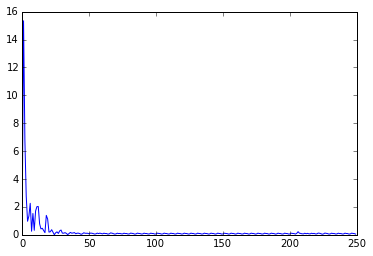

mean loss value: 0.257431030273


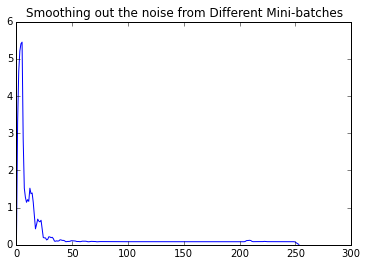

In [69]:


#plot loss
xAxis = range(len(costList))
print 'cost history'
plt.plot(xAxis, costList)
plt.show()


# too much noise
print "mean loss value: {}". format(np.mean(costList))

width_of_conv = len(startEnd) # smoothing over different mini-batches
convo = np.ones((width_of_conv)) * 1.0 / width_of_conv
convOut = np.convolve(costList, convo)

plt.plot(convOut)
plt.title('Smoothing out the noise from Different Mini-batches')
plt.show() # loss really is decreasing

# 4 layer network, with batch norm, exp decay, and drop out

In [70]:
# lower the learning rate as the training progresses.

tf.reset_default_graph() 
g = tf.Graph() 
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 784]) 
    Y = tf.placeholder(tf.float32, shape=[None, 2]) 


    
    [n_inputs, n_outputs] = weight_shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))  #from glorot paper
    w1 = tf.Variable(tf.random_normal([784,625], stddev=0.1), name='w1')
    w2 = tf.Variable(tf.random_normal([625,300], stddev=0.1), name='w2')
    w3 = tf.Variable(tf.random_normal([300,2], stddev=0.1), name='w3')
    
    b1 = tf.Variable(tf.zeros([1,625],dtype=tf.float32), name='b1')
    b2 = tf.Variable(tf.zeros([1,300],dtype=tf.float32), name='b2')
    b3 = tf.Variable(tf.zeros([1,2],dtype=tf.float32), name='b3')
    
    
    epsilon = 1e-3

    h1 = tf.nn.relu(tf.matmul(X, w1)+b1)  #look under Neural Net -> Activation in API left column
    prob = .5
    h_1_drop = tf.nn.dropout(h1, prob)
    batch_mean1, batch_var1 = tf.nn.moments(h_1_drop,[0])
    
    h1_hat = (h1 - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    
    scale1 = tf.Variable(tf.ones([625]))
    beta1 = tf.Variable(tf.zeros([625]))
    
    BN1 = scale1 * h1_hat + beta1
    l1_BN = tf.nn.sigmoid(BN1)
    
    h2 = tf.nn.relu(tf.matmul(l1_BN, w2)+b2)
    
    batch_mean2, batch_var2 = tf.nn.moments(h2,[0])
    scale2 = tf.Variable(tf.ones([300]))
    beta2 = tf.Variable(tf.zeros([300]))
    h2_hat = tf.nn.batch_normalization(h2,batch_mean2,batch_var2,beta2,scale2,epsilon)
    
    logits = tf.matmul(h2_hat, w3) + b3
    py_x = tf.nn.softmax(logits)
    y_pred = tf.argmax(py_x, dimension=1)


    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost') # cost per image, minibatch_size by 1 matrix
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost') # average cost over all images. actual loss value

    #extract gradients
    #gradients = tf.train.AdadeltaOptimizer(.1).minimize(cost, var_list = [b1,b2,w1,w2])
    
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = 0.01
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100000, 0.96, staircase=True)

    
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    gvs = optimizer.compute_gradients(cost, var_list = [b1,b2,b3,w1,w2,w3])
    capped_gvs = [(tf.clip_by_value(grad, -.5, .5), var) for grad, var in gvs]
    clipped_grads = optimizer.apply_gradients(capped_gvs)
    #optimizer.apply_gradients(capped_gvs)
    # wow! 1 line to get gradient wrt to complicated cost function
    #take training steps; backpropogation
    
    #opt = tf.train.AdadeltaOptimizer(learning_rate=0.1)
    #grads_and_vars = opt.compute_gradients(loss, [1])
    #trainW = w.assign(w - lr * grads_and_var)

    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weights over time1', w1)
    summary3 = tf.histogram_summary('Weights over time2', w2)
    summary4 = tf.histogram_summary('Weights over time3', w3)  
    
    merged = tf.merge_summary([summary1, summary2,summary3,summary4]) 
    
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.initialize_all_variables())
    #writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 100
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 40
    iteration = 1
    keep_prob = tf.placeholder(tf.float32)
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            costVal, weight, tbSummary = sess.run([cost,clipped_grads, merged], feed_dict={X: xTrain[s:e,], Y: yTrain[s:e]})
            # When trainW is called, it will return the updated weights
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 1 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTest, keep_prob:1.0})
            print iPass, np.mean(np.argmax(yTest, axis=1) == testResult) #accuracy

# http://r2rt.com/implementing-batch-normalization-in-tensorflow.html
# http://stackoverflow.com/questions/36498127/how-to-effectively-apply-gradient-clipping-in-tensor-flow

0 0.754716981132
1 0.735849056604
2 0.723270440252
3 0.74213836478
4 0.748427672956
5 0.792452830189
6 0.798742138365
7 0.779874213836
8 0.779874213836
9 0.817610062893
10 0.811320754717
11 0.817610062893
12 0.817610062893
13 0.823899371069
14 0.786163522013
15 0.786163522013
16 0.786163522013
17 0.823899371069
18 0.823899371069
19 0.817610062893
20 0.823899371069
21 0.823899371069
22 0.792452830189
23 0.792452830189
24 0.823899371069
25 0.817610062893
26 0.823899371069
27 0.817610062893
28 0.823899371069
29 0.792452830189
30 0.792452830189
31 0.823899371069
32 0.823899371069
33 0.823899371069
34 0.817610062893
35 0.823899371069
36 0.823899371069
37 0.830188679245
38 0.823899371069
39 0.823899371069


cost history


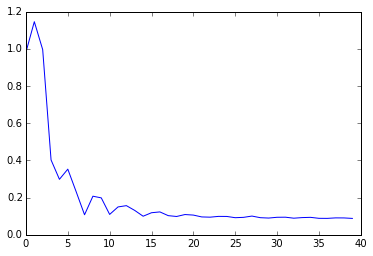

mean loss value: 0.199885770679


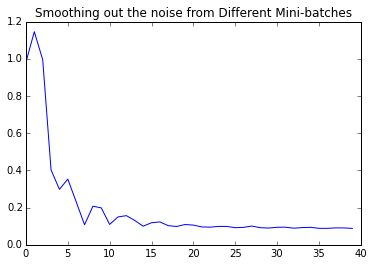

In [72]:

#plot loss
xAxis = range(len(costList))
print 'cost history'
plt.plot(xAxis, costList)
plt.show()


# too much noise
print "mean loss value: {}". format(np.mean(costList))

width_of_conv = len(startEnd) # smoothing over different mini-batches
convo = np.ones((width_of_conv)) * 1.0 / width_of_conv
convOut = np.convolve(costList, convo)

plt.plot(convOut)
plt.title('Smoothing out the noise from Different Mini-batches')
plt.show() # loss really is decreasing

# Conclusion/Future Work:
- image classification shows good promise on classifying files that proved difficult on typical text extraction methods
- more image collection
- build out new classes, birth certificate, transcripts, passports especially
- clone of text classifier
- if text classification didn't do well, try it as an image